# Neurons (using meshes)

This tutorial demonstrates how to generate smaller numbers of neuron objects, but with the added option of linking data or callbacks to the objects. Hovering over and clicking on the objects can then provide feedback to the Python API.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/urchin-examples/blob/main/basics/neurons_meshes.ipynb)

## Install Urchin

Urchin is a Python package stored on PyPI, the following code needs to be run the first time you use Urchin in a Python environment. 

Urchin's full documentation can be found [on our website](https://virtualbrainlab.org/urchin/installation_and_use.html).

In [ ]:
#Installing urchin
!pip install oursin -U

## Load data

In [1]:
import numpy as np
import pandas as pd
import requests
import io

In [2]:

def download_google_drive_data(file_id):

    # Construct the direct download link
    download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
    response = requests.get(download_url)

    if response.status_code == 200:
        data = pd.read_csv(io.BytesIO(response.content))
    else:
        response.raise_for_status()

    return data

# original file ultra_coords.csv: https://drive.google.com/drive/u/1/folders/1vwMFqh_GbglQcINFz55M64imAMFiNA4R
coords = download_google_drive_data('1f01isLBLL43eui94sCATv7LSRg_1qa9E')

In [3]:
print(coords)

          ap      dv      lr area   color  ignore    dur   wave
0     8525.0   750.0  3825.0  VIS  08858C       0  False  False
1     8525.0   750.0  3825.0  VIS  08858C       0  False  False
2     8525.0   725.0  3850.0  VIS  08858C       0  False  False
3     8525.0   700.0  3850.0  VIS  08858C       0  False  False
4     8525.0   700.0  3850.0  VIS  08858C       0  False  False
...      ...     ...     ...  ...     ...     ...    ...    ...
5891  6475.0  4450.0  7425.0  VPL  FF8084       0  False  False
5892  6475.0  4400.0  7425.0  VPL  FF8084       0   True   True
5893  6400.0  4700.0  7400.0  VPL  FF8084       0  False  False
5894  6475.0  4400.0  7425.0  VPL  FF8084       0   True  False
5895  6475.0  4425.0  7425.0  VPL  FF8084       0  False   True

[5896 rows x 8 columns]


## Setup Urchin and open the renderer webpage 

By default Urchin opens the 3D renderer in a webpage. Make sure pop-ups are enabled, or the page won't open properly. You can also open the renderer site yourself by replacing [ID here] with the ID that is output by the call to `.setup()` at https://data.virtualbrainlab.org/Urchin/?ID=[ID here]

Note that Urchin communicates to the renderer webpage through an internet connection, we don't currently support offline use (we hope to add support in the future).

In [4]:
#Importing necessary libraries:
import oursin as urchin
urchin.setup()

(URN) connected to server
Login sent with ID: d1d8ea80, copy this ID into the renderer to connect.


In [5]:
urchin.ccf25.load()

In [10]:
defaults = ['FRP','MO','SS','GU','VISC','AUD','VIS','ACA','PL',
            'ILA','ORB','AI','RSP','PTLp','TEa','PERI','OLF',
            'ECT','HPF','CTXsp','CNU','BS','CB']
area_list = urchin.ccf25.get_areas(defaults)
urchin.ccf25.set_visibilities(area_list, True, urchin.utils.Side.FULL, push = False)
urchin.ccf25.set_materials(area_list, 'transparent-unlit', push = False)
urchin.ccf25.set_alphas(area_list, 0.15)

You probably noticed that we set `push = False` on the first two `set_` calls above. This prevented Urchin from sending the updates to the renderer, which reduces data transfer when you are updating multiple aspects of the data at once. We left `push` on it's default value of `True` in the last call to send all the updates simultaneously.

## Creating meshes

To create mesh objects we'll call `urchin.primitives.create(n)`, passing the number of objects as a parameter.

In [12]:
pmeshes = urchin.meshes.create(len(coords), interactive=True) #creates 2 primitives, stored in list pmeshes

In [13]:
# reorder to AP/ML/DV for Urchin and make a list of lists
coords_list = []
for i, row in coords.iterrows():
  coords_list.append([row['ap'], row['lr'], row['dv']])
colors_list = [[0.0,0.0,0.0]]*len(coords)
sizes_list = [[0.02,0.02,0.02]]*len(coords)

urchin.meshes.set_positions(pmeshes,coords_list) #sets the positions of the primitives
urchin.meshes.set_colors(pmeshes, colors_list)
urchin.meshes.set_scales(pmeshes, sizes_list)

In [14]:
urchin.camera.main.set_rotation([22.5, 22.5, 225])
urchin.camera.main.set_mode('perspective')
urchin.camera.main.set_zoom(45)
urchin.camera.main.set_background_color('#ffffff')

(Camera receive) Camera CameraMain received an image
(URN) disconnected from server
(URN) connected to server
Login sent with ID: 5d63d0cc, copy this ID into the renderer to connect.


(Camera receive) CameraMain complete


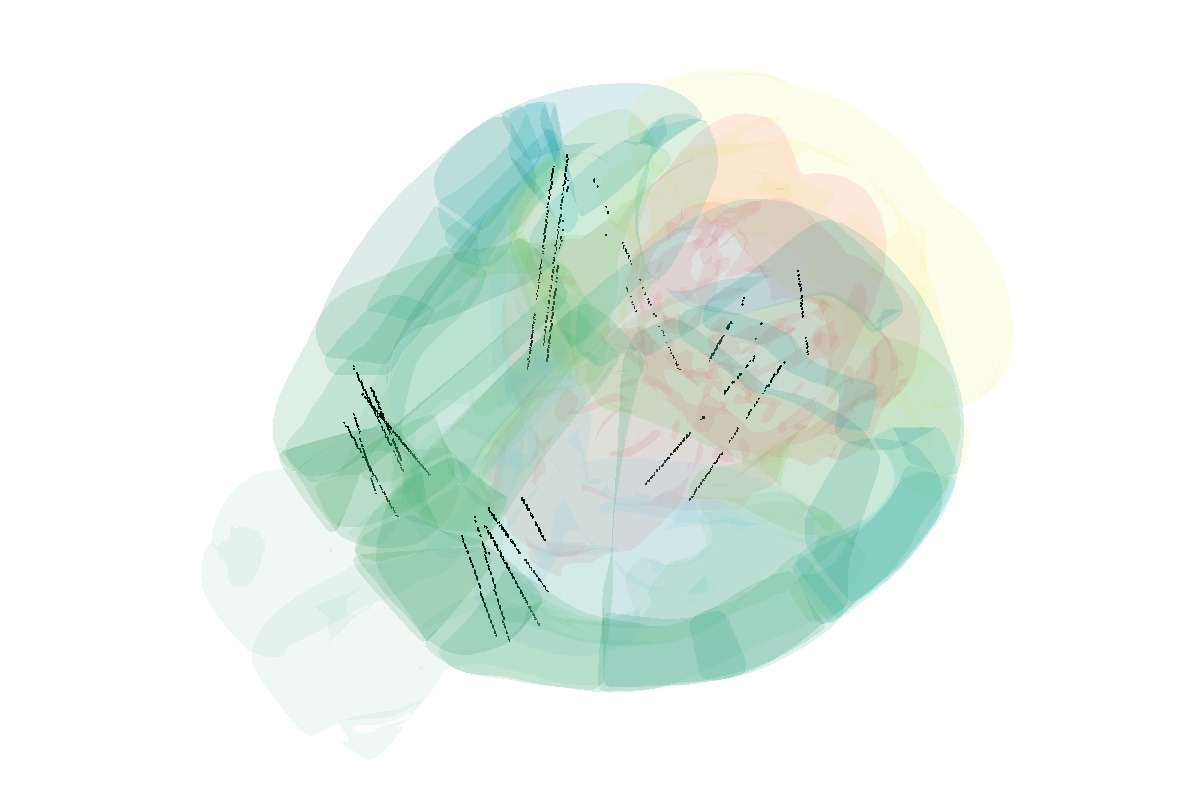

In [15]:
await urchin.camera.main.screenshot(size=[1200,800])

In [14]:
# Now let's set all the meshes to the color of the area they are inside of
colors_list = []
for i, row in coords.iterrows():
  colors_list.append(row['color'])

urchin.meshes.set_colors(pmeshes, colors_list)

## Getting callback information back

You can define a custom callback function in Python by attaching it to `urchin.meshes.callback`. The input parameter will receive the index positions of the clicked neurons as a string.

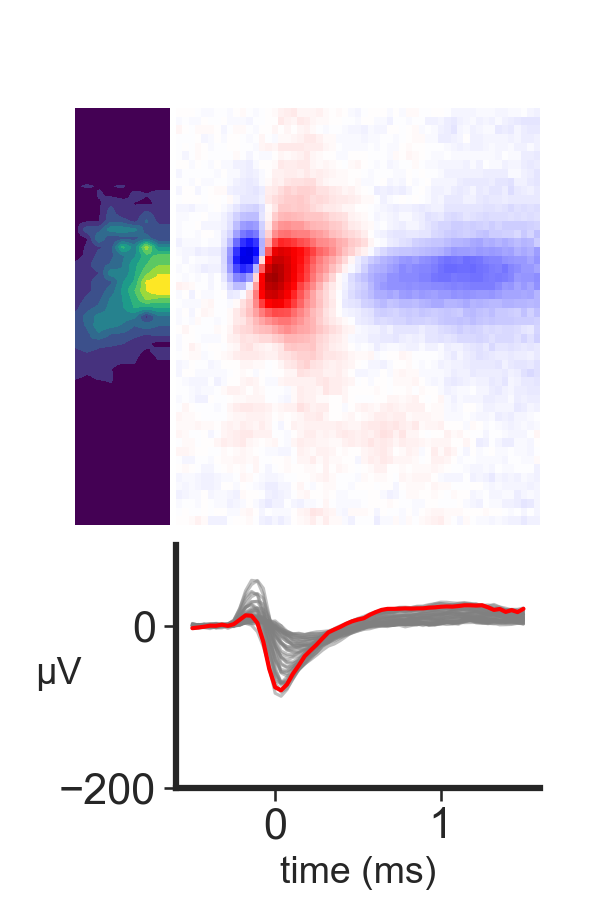

In [16]:
import requests
from IPython.display import display, Image, clear_output

def display_png_image(image_idx):
    # Construct the URL with the input parameter
    url = f'https://data.virtualbrainlab.org/Ultra/waveform{image_idx}.png'
    
    # Fetch the image using requests
    response = requests.get(url)
    
    if response.status_code == 200:
        # Display the image
        clear_output(wait=True)
        display(Image(data=response.content))
    else:
        print(f"Failed to fetch the image. Status code: {response.status_code}")

urchin.meshes.callback = display_png_image